# Visualizing Orbitals Using Hydrogen-Like Wave Functions
- [Angular Part](#ang)
- [Radial Part](#rad)
- [Overall Wave Functions: Probability Density](#pd)

**Later cells in this notebook depend on earlier cells. The posted binder should be in a state with all cells run and widgets at defaults, otherwise restart kernel and run all.**

This notebook may be cleaned up in the future its main purpose is to document the math behind the [main notebook](mnbspec).

In [1]:
from sympy import *
init_printing()
x, n, k, alpha, l, m, r, theta, phi, Z, a_0, sigma = symbols("x n k alpha l m r theta phi Z a_0 sigma")

# Angular Part<a id="ang"></a>

Construct the (real-valued) angular parts of the wave function $Y_l^{\left|m\right|}(\theta,\phi)$

Define the Legendre polynomials using Rodrigues' formula:

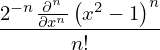

In [2]:
Legendre = 1/(2**n*factorial(n)) * ((x**2-1)**n).diff((x,n))
Legendre

Throughout this notebook, test these iterative formulas by printing the first few with sympy pretty printing.

First few Legendre polynomials, $P_n(x)=$

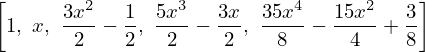

In [3]:
Ls = []
for i in range(5):
    L_i = expand(Legendre.subs(n,i).doit())
    Ls.append(L_i)
Ls

Define the "physicists'" associated Legendre polynomials, $P_l^m(x)=$

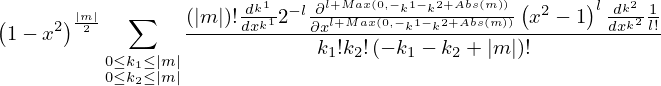

In [4]:
ALegendre = (1-x**2)**(abs(m)/2) * (Legendre.subs(n,l)).diff((x,abs(m)))
ALegendre

SymPy doesn't simplify that well but it's just

$\large P_l^m(x) = (1-x^2)^{\left|m\right|/2} \frac{d^{\left|m\right|}}{dx^{\left|m\right|}} P_l$

This is as far as we can go with a symbolic expression since we need to substitute $\cos\theta$ for $x$ and SymPy can't handle a derivative with respect to $\cos\theta$, so make a function to generate the final $n^{\text{th}},l^{\text{th}}$ Associated Legendre polynomial:

In [5]:
def P(given_l,given_m):
    return ALegendre.subs([(l,given_l),(m,given_m)]).doit().subs(x,cos(theta)).simplify().subs(((sin(theta))**2)**(1/2),sin(theta))

That last substitution in the above line isn't true in general but is here since $0 \le \theta < \pi$.

List out the first few $P_l^{\left|m\right|}(\cos\theta)$ for $l \le 2$:

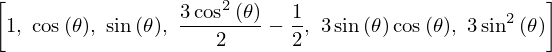

In [6]:
FinalLs = []
for i in range(3):
    for j in range(i+1):
        FinalLs.append(P(i,j))
FinalLs

Now define the complex spherical harmonics

$\large Y_l^m(\theta,\phi) = \sqrt{\frac{2l+1}{4\pi}\frac{(l-\left|m\right|)!}{(l+\left|m\right|)!}} P_l^{\left|m\right|}(cos\theta) e^{im\phi}$

In [7]:
def Y(given_l,given_m):
    return (sqrt( ((2*l+1)/(4*pi)) * factorial(l-abs(m))/factorial(l+abs(m)) ) * exp(I*m*phi)).subs([(l,given_l),(m,given_m)]) * P(given_l,given_m)

The first few $Y_l^m$ for $l \le 2$:

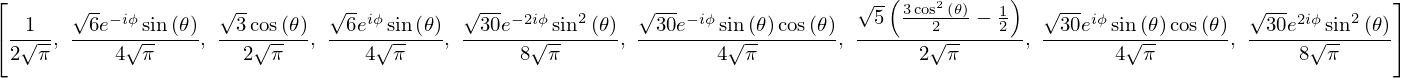

In [8]:
Ys = []
for i in range(3):
    for j in range(-i,i+1):
        Ys.append(Y(i,j))
Ys

## Real vs. Complex Spherical Harmonics

Notice that the only difference between $\pm m$ in the above is the sign of the exponent. Expanding that exponent out shows that changing the sign of $m$ does not change $\Re Y$, and only flips the sign of $\Im Y$.

#TODO: plot with a color map as complex phase, with that implemented, changing $m$ to $-m$ should flip colors

For $\left|m\right| > 0$, the corresponding $Y$s for $+m$ and $-m$ are both eigenfunctions of the angular Hamiltonian representing the same energy, therefore any superposition of them is an eigenfunction as well. The custom is to construct a real-valued $Y$ as the normalized combination of the corresponding $Y$s for $\pm m$, e.g. for $n=2, l=1, m=\pm1$:

$\large Y_{2p_x} = \frac{1}{\sqrt{2}}(Y_1^1+Y_1^{-1}) = \sqrt\frac{3}{4\pi}\sin\theta\cos\phi = \sqrt\frac{3}{4\pi}\frac{x}{r}$

$\large Y_{2p_y} = \frac{1}{\sqrt{2}i}(Y_1^1-Y_1^{-1}) = \sqrt\frac{3}{4\pi}\sin\theta\sin\phi = \sqrt\frac{3}{4\pi}\frac{y}{r}$

By converting these into Cartesian coordinates $(x=r\sin\theta\cos\phi, y=r\sin\theta\sin\phi, z=r\cos\theta)$, we can see the change of orientation in space. This naming convention $3d_{z^2}, 3d_{x^2-y^2}$, etc. can be derived by converting the corresponding real spherical harmonic into Cartesian coordiantes.

For the rest of this notebook, these two options for a given $\left|m\right|$ are referred to as the $+$ and $-$ options.

Using the above, construct the real spherical harmonics:

In [9]:
def real_Y(l,mag_m,*pm):
    if mag_m == 0:
        return Y(l,mag_m)
    elif pm:
        if pm[0] == "-":
            return simplify((1/(sqrt(2)*I)) * (Y(l,mag_m) - Y(l,-mag_m)))
    return simplify((1/sqrt(2)) * (Y(l,mag_m) + Y(l,-mag_m)))
    # defaults to the + option if no plus/minus given

The first few real-valued $Y_l^{\left|m\right|}$ for $l\le2$:

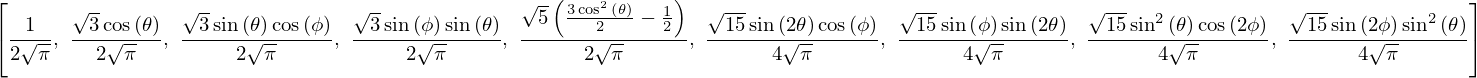

In [10]:
realYs = []
for i in range(3):
    for j in range(i+1):
        if j == 0:
            realYs.append(real_Y(i,j))
        else:
            realYs.append(real_Y(i,j,"+"))
            realYs.append(real_Y(i,j,"-"))
realYs

## Visualize Spherical Harmonics

In [11]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d

def plotter(sympy_f):
    # Put the sympy symbolic expression in something numpy 
    # (and therefore matplotlib) can understand
    f = lambdify([theta,phi],sympy_f,"numpy")
    
    t, p = np.linspace(0, np.pi, 40), np.linspace(0, 2*np.pi, 40)
    THETA, PHI = np.meshgrid(t, p)
    R = abs(f(THETA,PHI).real) # plot mag(Re(Y_l^m))
    X = R * np.sin(THETA) * np.cos(PHI)
    Y = R * np.sin(THETA) * np.sin(PHI)
    Z = R * np.cos(THETA)
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    plot = ax.plot_surface(
        X, Y, Z, rstride=1, cstride=1, cmap=plt.get_cmap('jet'),
        linewidth=0, antialiased=False, alpha=0.5)

    ax.set_xlim(-np.amax(R),np.amax(R))
    ax.set_ylim(-np.amax(R),np.amax(R))
    ax.set_zlim(-np.amax(R),np.amax(R))

    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$z$')

    plt.show()

In [12]:
# Make a simple GUI to pick which to plot:
import ipywidgets as wg

# Set up tabs for real vs. complex harmonics
def tab_contents(isReal):
    contents = [
        wg.BoundedIntText(value=0, min=0, description="$l$"),
        wg.BoundedIntText(value=0, min=0, max=0, description=f"{'$|m|$' if isReal else '$m$'}"),
        wg.Button(description="Generate Plot"),
        wg.Output()
    ]
    if isReal:
        contents.insert(
            2,
            wg.RadioButtons(options=["+","-"],
                            description="$Y_l^m \pm Y_l^{-m}$",
                            layout=wg.Layout(display="none")))
    return contents

tabs = wg.Tab()
tabs.set_title(0,"real")
tabs.set_title(1,"complex")
tabs.children = [
    wg.VBox(children=tab_contents(True)),
    wg.VBox(children=tab_contents(False))
]

def update_m_bounds(change):
    curTab = tabs.selected_index
    tabs.children[curTab].children[1].max = change["new"]
    if curTab:# i.e. if complex tab
        tabs.children[1].children[1].min = -change["new"]

def update_pm(change):
    if change["new"] > 0 and change["old"] == 0:
        tabs.children[0].children[2].layout.display = "flex" # show radio buttons
    elif change["new"] == 0 and change["old"] > 0:
        tabs.children[0].children[2].layout.display = "none" # hide radio buttons
    
        
def plot_caller(*args):
    curTab = tabs.selected_index
    curL = tabs.children[curTab].children[0].value
    curM = tabs.children[curTab].children[1].value
    plt.close()
    tabs.children[curTab].children[-1].clear_output()
    
    with tabs.children[curTab].children[-1]:
        if curTab: #i.e. if complex tab
            plotter(Y(curL,curM))
        else:
            plotter(real_Y(curL,curM,tabs.children[curTab].children[2].value))

tabs.children[0].children[0].observe(update_m_bounds, "value") #real tab
tabs.children[0].children[1].observe(update_pm, "value")
tabs.children[1].children[0].observe(update_m_bounds, "value") #complex tab
tabs.children[0].children[-2].on_click(plot_caller)
tabs.children[1].children[-2].on_click(plot_caller)
tabs

# Radial Part<a id="rad"></a>

Moving on, define the associated Laguerre polynomials $L_k^\alpha$:

In [13]:
def Laguerre(k,alpha):
    if k > 1:
        return expand(((-x + 2*k + alpha - 1)*Laguerre(k-1,alpha) - (k + alpha - 1)*Laguerre(k-2,alpha))/k)
    elif k == 1:
        return 1 + alpha - x
    else:
        return 1

What we need for the radial part are $L_{n-l-1}^{2l+1}$, shown below for $n\le4$:

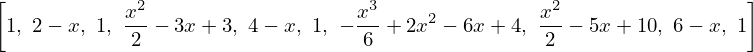

In [14]:
Lagus = []
for i in range(1,5):
    for j in range(i):
        Lagus.append(Laguerre(i-j-1,2*j+1))
        # these are the particular ones needed
Lagus

Make a function to return the specific $L_{n-l-1}^{2l+1}$ for a given $n,l$, with the substitution $\large \frac{2Zr}{na_0}$ for $x$:

In [15]:
def subsLaguerre(n,l,Z):
    res = Laguerre(n-l-1,2*l+1)
    if res == 1:
        return res
    else:
        return res.subs(x,2*Z*r/(n*a_0))

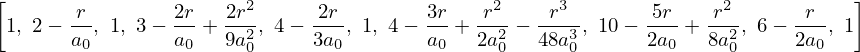

In [16]:
Lagus2 = []
for i in range(1,5):
    for j in range(i):
        Lagus2.append(subsLaguerre(i,j,1))
Lagus2

Now define the entire radial part:

In [17]:
def R(n,l,Z):
    return nsimplify((2/n)**(l+3/2)) * (Z/a_0)**(l+3/2) * sqrt(factorial(n-l-1)/(2*n*factorial(n+l))) * subsLaguerre(n,l,Z) * r**l * exp(-Z*r/(n*a_0))
    # The weird splitting up of terms is to get things to simplify cleanly

The radial parts $R_{n,l}$ for $n\le4$ are shown below, with the substiution $\sigma =$ $\large \frac{Zr}{a_0}$ for readability:

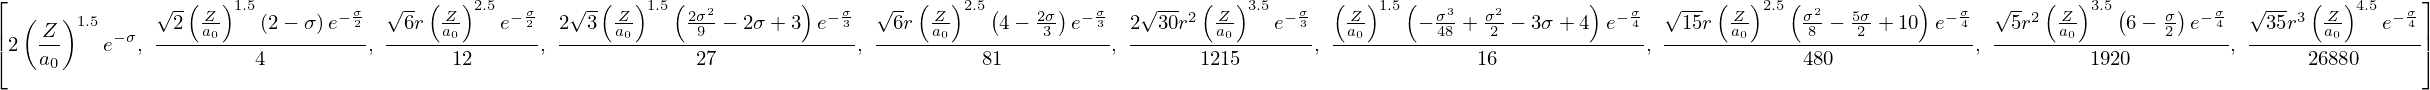

In [18]:
Rs = []
for i in range(1,5):
    for j in range(i):
        Rs.append(R(i,j,Z).subs(Z*r/a_0,sigma))
Rs

The normalization condition for $R_{n,l}$ is $\int_0^\infty R^*Rr^2 dr = 1$, the probability density is $f(r) dr = R^*Rr^2dr$, so $f(r) = r^2R^2$ since $R$ is real-valued. 

Classically, $\large E_n = \frac{1}{n^2}\frac{-q_e^4m_e}{8\epsilon_0^2h^2}$ and $\large V(r) = \frac{-Zq_e}{4\pi\epsilon_0r}$, and $E\le V$ so $\large r_n \le n^2 \frac{2Z\epsilon_0h^2}{\pi q_e^2m_e} = 2Zn^2a_0$.

Visualize this (the classically forbidden range is shaded in):

In [19]:
def R_plotter(n,l,Z):
    f = lambdify(r,(r**2*R(n,l,Z)**2).subs([(Z,1),(a_0,1)]),"numpy")
    
    r_Range = 10+20*(n-1) # how far to plot up to (in units of a_0)
    
    radius = np.linspace(0, r_Range, 1000)
    R_val = f(radius)
    
    fig, ax = plt.subplots()
    ax.plot(radius,R_val)
    
    plt.axvspan(2*Z*n**2, r_Range, facecolor='gray', alpha=0.15)
    
    ax.set_title(f"$f(r)$ for $R_{{{n}}}^{{{l}}}$")
    ax.set_xlabel("$r/a_0$")
    ax.set_ylabel("$f(r)$")

    plt.show()

In [20]:
# Radial GUI
R_n = wg.BoundedIntText(value=1,min=1,max=10,description=r"$n$")
R_l = wg.BoundedIntText(value=0,min=0,max=0,description=r"$l$")
R_Z = wg.BoundedIntText(value=1,min=1,max=180,description=r"$Z$")
R_button = wg.Button(description="Generate Plot")
R_out = wg.Output()
R_box = wg.HBox([R_n,R_l,R_Z,R_button])
R_GUI = wg.VBox([R_box,R_out])

def update_l_bounds(change):
    R_l.max = change["new"]-1

     
def R_plot_caller(*args):
    plt.close()
    R_out.clear_output()  
    with R_out:
        R_plotter(R_n.value, R_l.value, R_Z.value)

R_n.observe(update_l_bounds, "value")
R_button.on_click(R_plot_caller)
R_GUI

# Complete Wave Functions<a id="pd"></a>

Now the real-valued wave functions are simply $\psi_{n,l,m}(r,\theta,\phi) = R_{n,l}(r)Y_l^{\left|m\right|}(\theta,\phi)$:

In [21]:
def Psi(n,l,m,Z,*pm):
    if pm:
        return real_Y(l,m,pm[0])*R(n,l,Z)
    return real_Y(l,m)*R(n,l,Z)

The final hydrogen-like atomic wave functions for $n\le3$:

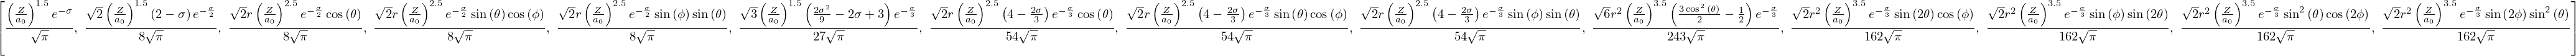

In [22]:
Psis = []
for i in range(1,4):
    for j in range(i):
        for k in range(j+1):
            if k == 0:
                Psis.append(Psi(i,j,k,Z).subs(Z*r/a_0,sigma))
                #substiution sigma = Zr/a_0 for readability
            else:
                Psis.append(Psi(i,j,k,Z,"+").subs(Z*r/a_0,sigma))
                Psis.append(Psi(i,j,k,Z,"-").subs(Z*r/a_0,sigma))

Psis

## Visualizing the final functions

Visualize the probability density by plotting random points within a certain radius and coloring them according to the value of  $\left|\psi\right|^2$ there.

Note $[\left|\psi\right|^2] = L^{-3}$ since $[\psi^*\psi r^2dr\sin\theta d\theta d\phi] = [\psi^*\psi dxdydz] = 1$.

In [23]:
# Visualize the probability densities
# by plotting random points in space and coloring them

from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable

def randrange(n, vmin, vmax):  
    return (vmax - vmin)*np.random.rand(n) + vmin

def Psi_plotter(n,l,m,Z,*pm):
    f = lambdify(
        [r,theta,phi],
        (Psi(n,l,m,Z,*pm).subs(a_0,1))**2,
        "numpy")
    
    r_Range = (10+20*(n-1))/2
    # in units of a_0.
    # there's probably some smart way to do this
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    
    # Redefine the inferno color map with scaled alpha (transparency)
    nColors = 256
    cArray = plt.get_cmap("inferno")(range(nColors))
    cArray[:,-1] = np.linspace(0.0,1.0,nColors)
    mapObj = LinearSegmentedColormap.from_list(
        name="inferno_alpha",colors=cArray)
    plt.register_cmap(cmap=mapObj)
    
    ax.set_facecolor('grey')
    fig.set_facecolor('grey')
    
    nPoints = 5000
    rs = randrange(nPoints, 0, r_Range)
    thetas = randrange(nPoints, 0, np.pi)
    phis = randrange(nPoints, 0, 2*np.pi)
    
    xs = rs * np.sin(thetas) * np.cos(phis)
    ys = rs * np.sin(thetas) * np.sin(phis)
    zs = rs * np.cos(thetas)
    
    ax.scatter(
        xs, ys, zs, marker="o",
        c=f(rs,thetas,phis), cmap = "inferno_alpha"
    )
    
    fig.colorbar(
        ScalarMappable(cmap="inferno_alpha",norm=Normalize(0,max(f(rs,thetas,phis)))),
        ax = ax,
        orientation = "vertical", pad = .15,
        label = r"$\left|\psi(r,\theta,\phi)\right|^2$ $(a_0^{-3})$"
    )
    
    ax.set_title(r"Probability Density")
    ax.set_xlim(-r_Range,r_Range)
    ax.set_ylim(-r_Range,r_Range)
    ax.set_zlim(-r_Range,r_Range)
    ax.view_init(5,-45)
    
    ax.set_xlabel(r'$x$ $(a_0)$')
    ax.set_ylabel(r'$y$ $(a_0)$')
    ax.set_zlabel(r'$z$ $(a_0)$')

    plt.show()

In [24]:
# Probability Density GUI

Psi_n = wg.BoundedIntText(value=1,min=1,max=10,description=r"$n$")
Psi_l = wg.BoundedIntText(value=0,min=0,max=0,description=r"$l$")
Psi_m = wg.BoundedIntText(value=1,min=0,max=0,description=r"$\left|m\right|$")
Psi_pm = wg.RadioButtons(options=["+","-"],description="$Y_l^m \pm Y_l^{-m}$", layout=wg.Layout(display="none"))
Psi_Z = wg.BoundedIntText(value=1,min=1,max=180,description=r"$Z$")
Psi_button = wg.Button(description="Generate Plot")
Psi_out = wg.Output()
Psi_box = wg.HBox([Psi_n,Psi_l,Psi_m,Psi_pm,Psi_Z,Psi_button])
Psi_GUI = wg.VBox([Psi_box,Psi_out])

def Psi_update_l_bounds(change):
    Psi_l.max = change["new"]-1
    
def Psi_update_m_bounds(change):
    Psi_m.max = change["new"]
    
def Psi_update_pm(change):
    if change["new"] > 0 and change["old"] == 0:
        Psi_pm.layout.display = "flex" # show radio buttons
    elif change["new"] == 0 and change["old"] > 0:
        Psi_pm.layout.display = "none" # hide radio buttons

def Psi_plot_caller(*args):
    plt.close()
    Psi_out.clear_output()  
    with Psi_out:
        Psi_plotter(Psi_n.value, Psi_l.value, Psi_m.value, Psi_Z.value, Psi_pm.value)

Psi_n.observe(Psi_update_l_bounds, "value")
Psi_l.observe(Psi_update_m_bounds, "value")
Psi_m.observe(Psi_update_pm, "value")
Psi_button.on_click(Psi_plot_caller)
Psi_GUI

Zoom (right click) and rotate these!